# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.679634,False,-2.593316
1,-0.441092,True,2.485349
2,1.145603,False,2.354726
3,-0.342231,True,5.452101
4,-1.336803,True,1.546126
...,...,...,...
995,-2.748101,False,-8.055462
996,2.153564,True,11.945566
997,1.272155,True,7.421047
998,-0.409430,True,4.439968


<AxesSubplot:xlabel='v0'>

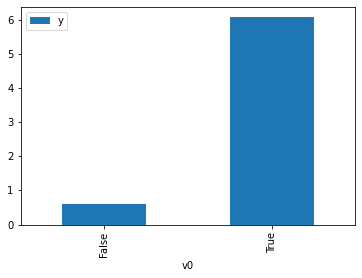

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

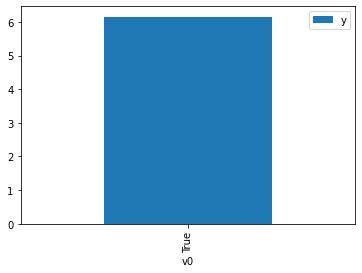

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.507299,False,-1.200376,0.713991,1.400579
1,0.003105,False,-1.482894,0.504084,1.983796
2,1.320254,False,5.186687,0.090928,10.997673
3,-0.544294,False,-1.838499,0.727102,1.375322
4,0.681023,False,1.395006,0.235581,4.244822
...,...,...,...,...,...
995,-0.362725,False,-0.841924,0.659336,1.516677
996,-0.667596,False,0.993312,0.767996,1.302090
997,1.320254,False,5.186687,0.090928,10.997673
998,-2.004134,False,-5.996709,0.972073,1.028729


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.035684,True,3.322262,0.136460,7.328140
1,-0.296226,True,2.655621,0.367426,2.721637
2,0.330571,True,5.485500,0.636483,1.571135
3,1.327160,True,7.953465,0.910072,1.098815
4,1.153169,True,8.366079,0.881657,1.134228
...,...,...,...,...,...
995,-0.236399,True,4.904518,0.392228,2.549537
996,1.383050,True,9.043595,0.917806,1.089555
997,-0.789128,True,2.746434,0.196081,5.099938
998,0.176135,True,5.531430,0.571571,1.749565


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.974
Method:                 Least Squares   F-statistic:                          1.903e+04
Date:                Mon, 08 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:56:41   Log-Likelihood:                         -1413.1
No. Observations:                1000   AIC:                                      2830.
Df Residuals:                     998   BIC:                                      2840.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7855      0.036     76.546      0.000       2.714       2.857
x2             5.1361      0.051    101.456      0.000       5.037       5.235
==============================================================================
Omnibus:                        0.687   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.709   Jarque-Bera (JB):                0.751
Skew:                          -0.059   Prob(JB):                        0.687
Kurtosis:                       2.935   Cond. No.                         2.12
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""